In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyross

## Introduction

In this notebook, we consider an SEAI5R model with a lockdown protocol that is put in place once the infective population exceeds a threshold, and is removed once the infective population falls below a second threshold.

Except for the lockdown protocol, the model considered here is the same as in *examples/deterministic/ex11-SEAI5R-UK.ipynb*.

**Note that while this example uses the UK age structure and contact matrix, the model parameters are not fitted to any real data, but chosen ad-hoc.**

## Load age groups and contact matrices

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

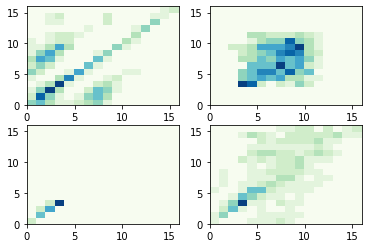

In [4]:
# contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()

## matrix of total contacts
C=CH+CW+CS+CO

fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

## Set system parameters

**The following model parameters are not fitted to any real data, but chosen ad-hoc.**

In [5]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 100*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[12:16] = -300            # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC



# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 1000*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

## Define events at which contact matrix is modified

For every change in the contact matrix that could occur, we have to define an *event*. An event is a function of time and the current state, and the event happens once the function becomes zero (from a given side).

The program expects 
* a list of events, and 
* a list of contact matrices.

If event $i$ takes place, then the $i$-th contact matrix from the list is used in the simulation.

The simulation always starts with the first contact matrix from the list, and the corresponding event can only occur once another event has occured (below we will use a dummy event that can never occur).

We now define three events:

In [6]:
events = []
contactMatrices = []

# Note that for technical reasons, the event functions take a
# vector argument "rp" instead of a tuple (S, E, A, Ia, Is, Ih, Ic, Im).
# When defining the event functions, the following correspondence has to be used:
# S  == rp[ :M]
# E  == rp[M:2*M]
# A  == rp[2*M:3*M]
# Ia == rp[3*M:4*M]
# Is == rp[4*M:5*M]
# Ih == rp[5*M:6*M]
# Ic == rp[6*M:7*M]
# Im == rp[7*M:8*M]

# This is a dummy event which will never occur; it is used to set the initial contact matrix
def cur_event(t,rp):
    return t + 1
cur_event.direction = +1
events.append(cur_event)
contactMatrices.append( C )

# Lockdown (= multiply beta by a factor 1/2) once number of infectives I_s becomes larger than 5000
lockdown_threshold_on = 100000
def cur_event2(t,rp):
    return np.sum(rp[4*M:5*M]) - lockdown_threshold_on
cur_event2.direction = +1 # this means we need to pass the threshold from below for the event to happen
events.append(cur_event2)
contactMatrices.append( CH ) #+CW+CS+CO )

# End of lockdown once number of infectives I_s becomes smaller than 1000 (and has been larger before)
lockdown_threshold_off = 10000
def cur_event3(t,rp):
    return np.sum(rp[4*M:5*M]) - lockdown_threshold_off
cur_event3.direction = -1 # this means we need to pass the threshold from above for the event to happen
events.append(cur_event3)
contactMatrices.append( C )

## Simulate system and plot result

(Note that we allow events to repeat, as set by the "events_repeat=True" option in model.simulate)

In [7]:
# duration of simulation and data file
Tf=200;  Nf=2000;  


# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni)

In [8]:
# Run simulation
Tf = 300
Nt = (Tf +1)*10

result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0 ,
                        events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                       events_repeat=True)

event_labels = ['','lockdown starts','lockdown ends']
for i,e in enumerate(result['events_occured']):
    print("After {0:3.1f} days, the {1}.".format(e[0],event_labels[e[1]]))

After 29.9 days, the lockdown starts.
After 118.2 days, the lockdown ends.
After 147.6 days, the lockdown starts.
After 231.6 days, the lockdown ends.
After 262.1 days, the lockdown starts.


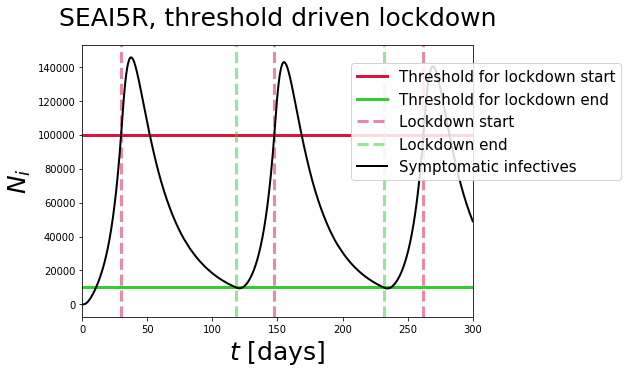

In [9]:
# Plot result
t_arr = result['t']
trajs = result['X'].T

fontsize=25
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.set_title('SEAI5R, threshold driven lockdown',
            y=1.05,fontsize=25)
ax.axhline(lockdown_threshold_on,color='crimson',
           lw=3,
           label='Threshold for lockdown start')
ax.axhline(lockdown_threshold_off,color='limegreen',
           lw=3,
          label='Threshold for lockdown end')
for i,e in enumerate(result['events_occured']):
    if e[1] == 1:
        color='crimson'
        if i < 2:
            label='Lockdown start'
        else:
            label= ''
    else:
        color='limegreen'
        if i < 2:
            label='Lockdown end'
        else:
            label= ''
    ax.axvline(e[0],label=label,
               color=color,
               lw=3,
               ls='--',alpha=0.5)


ax.plot(t_arr,np.sum(trajs[4*M:5*M],axis=0),
    label='Symptomatic infectives', 
    color='black',
    lw=2,
   )
ax.set_xlim(np.min(t_arr),np.max(t_arr))
ax.set_ylabel(r'$N_i$',fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,0.96),
          framealpha=0.85,
         fontsize=15)
plt.show()
plt.close()